# 📌 1. Загрузка данных (train.csv)

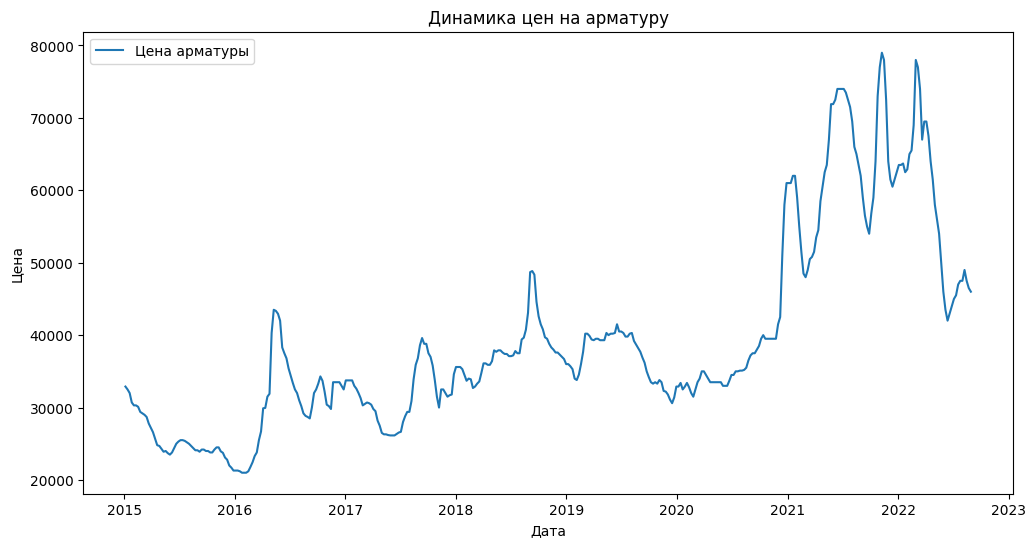

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle

# Загрузка данных
file_path = 'data/train.csv'  # Используем CSV
train_data = pd.read_csv(file_path, parse_dates=['dt'], index_col='dt')
train_data.rename(columns={'pfr': 'price'}, inplace=True)

# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Цена арматуры')
plt.title('Динамика цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()


# 📌 2. Проверка стационарности

In [5]:

# Функция проверки стационарности
def check_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print('Ряд не стационарен, требуется дифференцирование.')
    else:
        print('Ряд стационарен.')

check_stationarity(train_data['price'])

# Если ряд нестационарный, применяем дифференцирование
train_data['price_diff'] = train_data['price'].diff().dropna()
check_stationarity(train_data['price_diff'].dropna())


ADF Statistic: -1.9258699893713453
p-value: 0.3199906102569917
Ряд не стационарен, требуется дифференцирование.
ADF Statistic: -7.7060615041152065
p-value: 1.3006938373810178e-11
Ряд стационарен.


# 📌 3. ACF и PACF для выбора параметров p и q

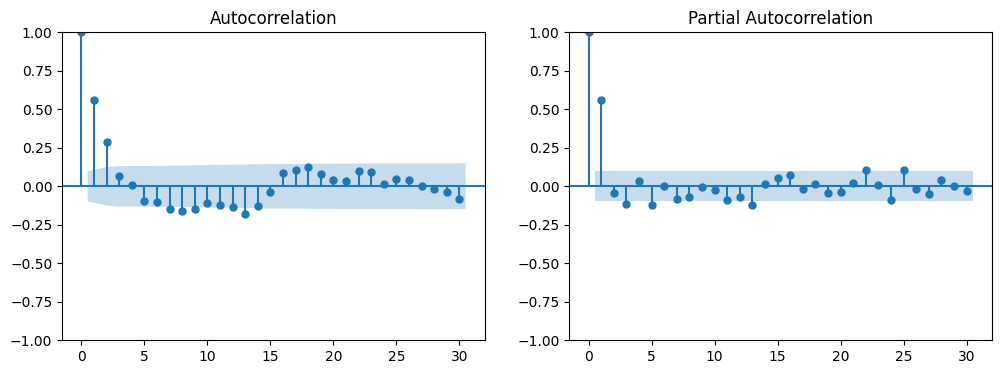

In [6]:

# ACF и PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_data['price_diff'].dropna(), ax=axes[0], lags=30)
plot_pacf(train_data['price_diff'].dropna(), ax=axes[1], lags=30)
plt.show()


# 📌 4. Обучение модели ARIMA

In [7]:
# Выбранные параметры (из ACF и PACF графиков)
p, d, q = 1, 1, 1

# Обучение модели ARIMA
model = ARIMA(train_data['price'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Сохранение модели
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)


C:\DeStep\WORK\Intensive_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\DeStep\WORK\Intensive_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
C:\DeStep\WORK\Intensive_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  400
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3487.541
Date:                Wed, 19 Mar 2025   AIC                           6981.082
Time:                        23:46:08   BIC                           6993.049
Sample:                    01-05-2015   HQIC                          6985.821
                         - 08-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3781      0.099      3.838      0.000       0.185       0.571
ma.L1          0.0016      0.115      0.014      0.989      -0.223       0.226
sigma2      1.988e+06   5.35e+04     37.130      0.0

# 📌 5. Прогнозирование цен

Прогноз цен на 6 недель: 2022-09-05    45810.750526
2022-09-12    45739.194141
2022-09-19    45712.138233
2022-09-26    45701.908229
2022-10-03    45698.040202
2022-10-10    45696.577677
Freq: W-MON, Name: predicted_mean, dtype: float64


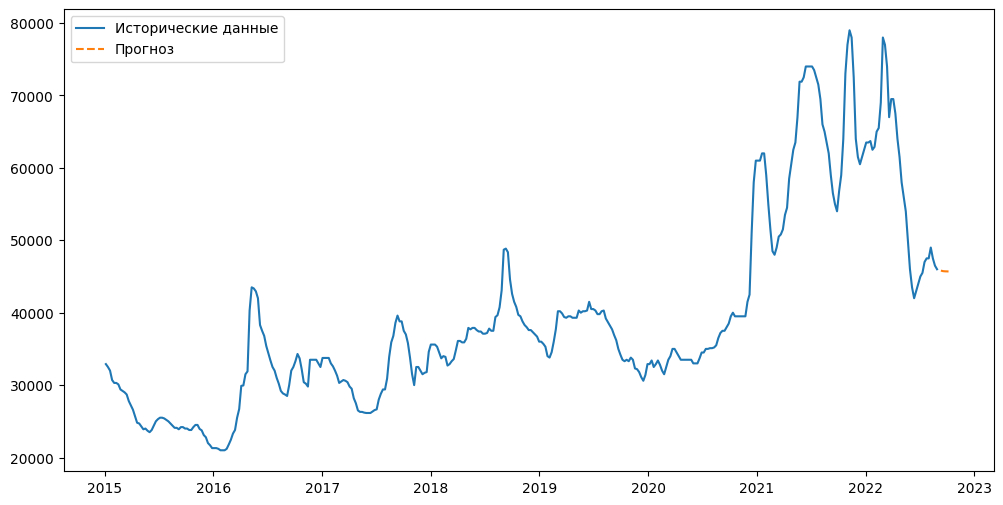

In [8]:

# Прогнозирование
forecast = model_fit.forecast(steps=6)
print(f'Прогноз цен на 6 недель: {forecast}')

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['price'], label='Исторические данные')
plt.plot(pd.date_range(train_data.index[-1], periods=7, freq='W')[1:], forecast, label='Прогноз', linestyle='dashed')
plt.legend()
plt.show()


# 📌 6. Загрузка и применение модели (test.csv)

In [10]:

# Загрузка обученной модели
with open('arima_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Загрузка тестовых данных
test_data = pd.read_csv('data/test.csv', parse_dates=['dt'], index_col='dt')

# Прогнозирование
forecast_steps = len(test_data)
test_data['forecast'] = model.forecast(steps=forecast_steps)


# 📌 7. Определение N (на сколько недель закупать)

In [13]:
# Определение N (Количество недель для закупки)
def determine_n(price_forecast_series):
    pct_change_mean = pd.Series(price_forecast_series).pct_change().mean()

    if pct_change_mean < 0:
        return 1  # Цена снижается → закупка на 1 неделю
    elif pct_change_mean > 0:
        return 6  # Цена растёт → закупка на 6 недель
    else:
        return 3  # Нейтральный прогноз

# Применяем функцию ко всему прогнозу
test_data['N'] = determine_n(test_data['forecast'].values)

# Сохранение результатов
test_data.to_csv('test_with_forecast.csv')

# 📌 8. Визуализация результатов

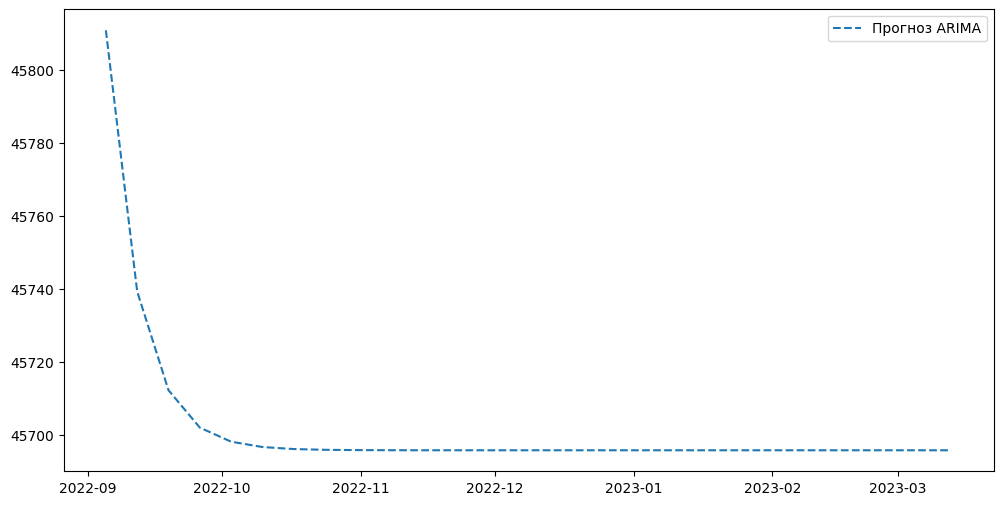

Прогноз сохранён в test_with_forecast.csv


In [14]:

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['forecast'], label='Прогноз ARIMA', linestyle='dashed')
plt.legend()
plt.show()

print("Прогноз сохранён в test_with_forecast.csv")
